In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
from pathlib import Path  
from tqdm import tqdm

## Preprocessing desc.
This does only basic things, this is like the core to build on. Simple filtering, universal for all iterations


### Useful info on datasets:
- 2023-2025 have the same dataset structure. 
- Null values don't occur in entries where NS is the train operator.
- There are some nulls in departure and arrival time, but it's just journey's beginning and end.
- Overall, the dataset's quality is high. All 0's and nulls are intentional.

### Features to remove:
a) Maximum delay (calculates stop with the most delay on the journey) irrelevant for prediction process
b) Date (we have much more details in arrival and departure date)
c) Company (we only use NS)
d) Train number (to not overcomplicate life)
e) Arrival/Departure partially cancelled (too complicated)
f) Planned and actual platform (we don't need it, there's a separate feature called Platform cancelled, it's more relevant)

### Features to add:
For now we don't add any features - enrichment will be done after we'll reorganize dataset into "journeys" with departure and arrival stations

### This parts cleaning process:
- Merge all datasets
- Remove unnecessary features
- NO GROUPING OF ANY KIND
- NO FEATURE ADDING OF ANY KIND (to be added later on)
- Limit entries to the ones which have NS as company and either sprinter or intercity as train types
- Finally, group by journey, and add max stops for every journey (technical feature) and stop id


In [3]:
def get_dataset_info(dataset): 
    dataset.info()

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# dataset_2023 = pd.read_csv('datasets/train_information_main_2023.csv') let's deal with the smaller dataset for now
dataset_2025_jan = pd.read_csv('datasets/train_information_main_2025-jan.csv')
# dataset_2024 = pd.read_csv('datasets/train_information_main_2024.csv')
dataset_2025_feb = pd.read_csv('datasets/train_information_main_2025-feb.csv')
dataset_2025_mar = pd.read_csv('datasets/train_information_main_2025-mar.csv')
one_big_merged_dataset = pd.concat([dataset_2025_jan, dataset_2025_feb, dataset_2025_mar])

In [6]:
get_dataset_info(one_big_merged_dataset)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5515606 entries, 0 to 1902542
Data columns (total 20 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Service:RDT-ID                int64  
 1   Service:Date                  object 
 2   Service:Type                  object 
 3   Service:Company               object 
 4   Service:Train number          int64  
 5   Service:Completely cancelled  bool   
 6   Service:Partly cancelled      bool   
 7   Service:Maximum delay         int64  
 8   Stop:RDT-ID                   int64  
 9   Stop:Station code             object 
 10  Stop:Station name             object 
 11  Stop:Arrival time             object 
 12  Stop:Arrival delay            float64
 13  Stop:Arrival cancelled        object 
 14  Stop:Departure time           object 
 15  Stop:Departure delay          float64
 16  Stop:Departure cancelled      object 
 17  Stop:Platform change          bool   
 18  Stop:Planned platform 

In [7]:
one_big_merged_dataset.head()

,Service:RDT-ID,Service:Date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Planned platform,Stop:Actual platform
0,15086865,2025-01-01,Intercity,NS,1410,False,False,1,136167814,RTD,Rotterdam Centraal,NaN,NaN,NaN,2025-01-01T02:02:00+01:00,0.0,False,False,8,8
1,15086865,2025-01-01,Intercity,NS,1410,False,False,0,136167815,DT,Delft,2025-01-01T02:12:00+01:00,1.0,False,2025-01-01T02:12:00+01:00,1.0,False,False,1,1
2,15086865,2025-01-01,Intercity,NS,1410,False,False,0,136167816,GV,Den Haag HS,2025-01-01T02:19:00+01:00,1.0,False,2025-01-01T02:22:00+01:00,0.0,False,False,6,6
3,15086865,2025-01-01,Intercity,NS,1410,False,False,0,136167817,LEDN,Leiden Centraal,2025-01-01T02:31:00+01:00,0.0,False,2025-01-01T02:33:00+01:00,0.0,False,False,5b,5b
4,15086865,2025-01-01,Intercity,NS,1410,False,False,0,136167818,SHL,Schiphol Airport,2025-01-01T02:56:00+01:00,0.0,False,2025-01-01T02:59:00+01:00,0.0,False,True,1/2,2


In [8]:
#Make NS the only selected company (narrowing the scope) and make Sprinter and intercity only train types
one_big_merged_dataset = one_big_merged_dataset[one_big_merged_dataset['Service:Company'] == "NS"]
one_big_merged_dataset = one_big_merged_dataset[
    one_big_merged_dataset['Service:Type'].isin(["Sprinter", "Intercity"])
]

In [9]:
def column_null_overview(df: pd.DataFrame):
    null_counts = (df.isna() | df.eq('')).sum()   # vectorised, very fast
    overview = null_counts.to_dict()
    print(overview)
    return overview

In [10]:
column_null_overview(one_big_merged_dataset)

{'Service:RDT-ID': 0, 'Service:Date': 0, 'Service:Type': 0, 'Service:Company': 0, 'Service:Train number': 0, 'Service:Completely cancelled': 0, 'Service:Partly cancelled': 0, 'Service:Maximum delay': 0, 'Stop:RDT-ID': 0, 'Stop:Station code': 0, 'Stop:Station name': 0, 'Stop:Arrival time': 324748, 'Stop:Arrival delay': 324748, 'Stop:Arrival cancelled': 324748, 'Stop:Departure time': 324897, 'Stop:Departure delay': 324897, 'Stop:Departure cancelled': 324897, 'Stop:Platform change': 0, 'Stop:Planned platform': 189970, 'Stop:Actual platform': 189970}


{'Service:RDT-ID': 0,
 'Service:Date': 0,
 'Service:Type': 0,
 'Service:Company': 0,
 'Service:Train number': 0,
 'Service:Completely cancelled': 0,
 'Service:Partly cancelled': 0,
 'Service:Maximum delay': 0,
 'Stop:RDT-ID': 0,
 'Stop:Station code': 0,
 'Stop:Station name': 0,
 'Stop:Arrival time': 324748,
 'Stop:Arrival delay': 324748,
 'Stop:Arrival cancelled': 324748,
 'Stop:Departure time': 324897,
 'Stop:Departure delay': 324897,
 'Stop:Departure cancelled': 324897,
 'Stop:Platform change': 0,
 'Stop:Planned platform': 189970,
 'Stop:Actual platform': 189970}

In [11]:
def remove_unnecessary_features(df):
    columns_to_remove = [
        'Service:Maximum delay',
        'Service:Date',
        'Service:Company',
        'Service:Train number',
        'Service:Partly cancelled',
        "Stop:Planned platform",
        "Stop:Actual platform"
    ]

    # Ensure only existing columns are removed
    columns_to_remove = [col for col in columns_to_remove if col in df.columns]

    # Drop the columns
    cleaned_df = df.drop(columns=columns_to_remove)

    return cleaned_df


In [12]:
one_big_merged_dataset = remove_unnecessary_features(one_big_merged_dataset)

In [13]:
def empty_values_sorting(dataset):
    mask = dataset["Stop:Arrival delay"].isna()
    dataset.loc[mask, "Stop:Arrival delay"] = 0
    mask = dataset["Stop:Departure delay"].isna()
    dataset.loc[mask, "Stop:Departure delay"] = 0
    mask = dataset["Stop:Departure cancelled"].isna()
    dataset.loc[mask, "Stop:Departure cancelled"] = False
    mask = dataset["Stop:Arrival cancelled"].isna()
    dataset.loc[mask, "Stop:Arrival cancelled"] = False
    return dataset

In [14]:
one_big_merged_dataset = empty_values_sorting(one_big_merged_dataset)

In [15]:
def plot_bar_chart(label, basic_info):
    grouped_data = basic_info.groupby(label).size()
    
    # Plot the bar chart
    grouped_data.plot(kind='bar', color='navajowhite', edgecolor='black')
    
    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Count')
    plt.title('Distribution of ' + label)
    
    # Add percentages on top of each bar
    total_count = len(basic_info)  # Total number of entries in the DataFrame
    for i, value in enumerate(grouped_data):
        percentage = (value / total_count) * 100
        plt.text(i, value + 0.1, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=8)
    
    # Show the plot
    plt.show()

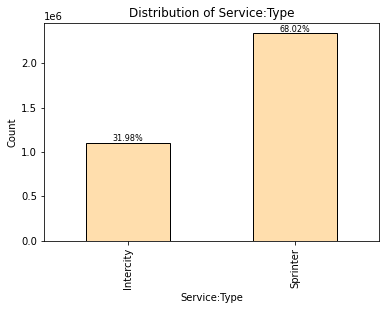

In [16]:
plot_bar_chart("Service:Type", one_big_merged_dataset)

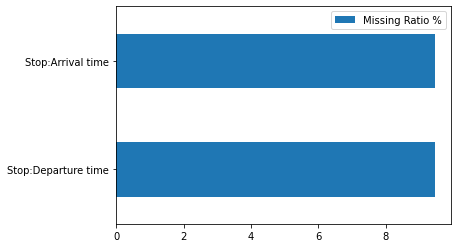

In [17]:
def plot_nas(df: pd.DataFrame):
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NAs found')
plot_nas(one_big_merged_dataset)

In [18]:
one_big_merged_dataset.head()

,Service:RDT-ID,Service:Type,Service:Completely cancelled,Stop:RDT-ID,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change
0,15086865,Intercity,False,136167814,RTD,Rotterdam Centraal,NaN,0.0,False,2025-01-01T02:02:00+01:00,0.0,False,False
1,15086865,Intercity,False,136167815,DT,Delft,2025-01-01T02:12:00+01:00,1.0,False,2025-01-01T02:12:00+01:00,1.0,False,False
2,15086865,Intercity,False,136167816,GV,Den Haag HS,2025-01-01T02:19:00+01:00,1.0,False,2025-01-01T02:22:00+01:00,0.0,False,False
3,15086865,Intercity,False,136167817,LEDN,Leiden Centraal,2025-01-01T02:31:00+01:00,0.0,False,2025-01-01T02:33:00+01:00,0.0,False,False
4,15086865,Intercity,False,136167818,SHL,Schiphol Airport,2025-01-01T02:56:00+01:00,0.0,False,2025-01-01T02:59:00+01:00,0.0,False,True


In [19]:
print(len(one_big_merged_dataset))

3436895


In [20]:
print(one_big_merged_dataset['Service:RDT-ID'].nunique())


324579


In [21]:
one_big_merged_dataset.drop("Stop:RDT-ID", inplace = True, axis = 1)
one_big_merged_dataset['Stop:Number'] = one_big_merged_dataset.groupby('Service:RDT-ID').cumcount() + 1
one_big_merged_dataset['Technical:Max-Stop-Num'] = (
    one_big_merged_dataset.groupby('Service:RDT-ID')['Stop:Number'].transform('max')
)

In [22]:
one_big_merged_dataset.to_csv('preprocessed_data/basic_preprocessed_light.csv', index=False)

In [23]:
one_big_merged_dataset.head(10)

,Service:RDT-ID,Service:Type,Service:Completely cancelled,Stop:Station code,Stop:Station name,Stop:Arrival time,Stop:Arrival delay,Stop:Arrival cancelled,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,Stop:Platform change,Stop:Number,Technical:Max-Stop-Num
0,15086865,Intercity,False,RTD,Rotterdam Centraal,NaN,0.0,False,2025-01-01T02:02:00+01:00,0.0,False,False,1,9
1,15086865,Intercity,False,DT,Delft,2025-01-01T02:12:00+01:00,1.0,False,2025-01-01T02:12:00+01:00,1.0,False,False,2,9
2,15086865,Intercity,False,GV,Den Haag HS,2025-01-01T02:19:00+01:00,1.0,False,2025-01-01T02:22:00+01:00,0.0,False,False,3,9
3,15086865,Intercity,False,LEDN,Leiden Centraal,2025-01-01T02:31:00+01:00,0.0,False,2025-01-01T02:33:00+01:00,0.0,False,False,4,9
4,15086865,Intercity,False,SHL,Schiphol Airport,2025-01-01T02:56:00+01:00,0.0,False,2025-01-01T02:59:00+01:00,0.0,False,True,5,9
5,15086865,Intercity,False,ASS,Amsterdam Sloterdijk,2025-01-01T03:07:00+01:00,0.0,False,2025-01-01T03:09:00+01:00,0.0,False,False,6,9
6,15086865,Intercity,False,ASD,Amsterdam Centraal,2025-01-01T03:15:00+01:00,0.0,False,2025-01-01T03:19:00+01:00,0.0,False,False,7,9
7,15086865,Intercity,False,ASB,Amsterdam Bijlmer ArenA,2025-01-01T03:29:00+01:00,0.0,False,2025-01-01T03:30:00+01:00,0.0,False,False,8,9
8,15086865,Intercity,False,UT,Utrecht Centraal,2025-01-01T03:46:00+01:00,0.0,False,NaN,0.0,False,False,9,9
9,15086866,Intercity,False,ASD,Amsterdam Centraal,NaN,0.0,False,2025-01-01T02:05:00+01:00,23.0,False,False,1,3
